# Detection of Facemask in Real Time using CV2 and TensorFlow

# Packages to be installed.

In [1]:
#if the following packages are not available try to install these packages
#pip install opencv-python
#pip install tensorflow
#pip install mtcnn
#pip install imutils
#pip install PIL
#pip install numpy

# Importing the Packages

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import cv2
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import PIL
import numpy as np
import os

In [3]:
#Importing the dataset which contains pictures of Masked and unmasked people faces.

imagePaths = list(paths.list_images('C:/Users/Shivamani/face detection mask dataset'))
data = []
labels = []
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

C:\Users\Shivamani\anaconda33\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [4]:
#Creating a machine learning model using MobileNetV2 to train the datasets.

baseModel = MobileNetV2(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [5]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

In [6]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,validation_data=(testX, testY),validation_steps=len(testX) // BS,epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
95/95 [==============================] - 90s 943ms/step - loss: 0.3378 - accuracy: 0.8546 - val_loss: 0.0981 - val_accuracy: 0.9804
Epoch 2/20
95/95 [==============================] - 87s 914ms/step - loss: 0.1206 - accuracy: 0.9595 - val_loss: 0.0567 - val_accuracy: 0.9896
Epoch 3/20
95/95 [==============================] - 92s 970ms/step - loss: 0.0760 - accuracy: 0.9763 - val_loss: 0.0472 - val_accuracy: 0.9922
Epoch 4/20
95/95 [==============================] - 86s 905ms/step - loss: 0.0663 - accuracy: 0.9812 - val_loss: 0.0407 - val_accuracy: 0.9896
Epoch 5/20
95/95 [==============================] - 85s 892ms/step - loss: 0.0603 - accuracy: 0.9806 - val_loss: 0.0352 - val_accuracy: 0.9935
Epoch 6/20
95/95 [==============================] - 85s 893ms/step - loss: 0.0525 - accuracy: 0.9832 - val_loss: 0.0324 - val_accuracy: 0.9935
Epoch 7/20
95/95 [==============================] - 84s 883ms/step - loss: 0.0478 - accuracy

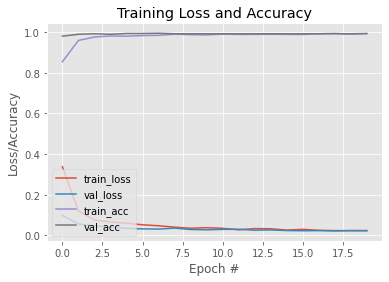

In [7]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [8]:
#saving the Trained Model which is to be used for detection.

model.save('facemask_recognition_model.h5')

# Face detection using the trained model

In [11]:
faceCascade=cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')
model=load_model('facemask_recognition_model.h5')
video_capture = cv2.VideoCapture(0)
while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(60, 60),flags=cv2.CASCADE_SCALE_IMAGE)
    faces_list=[]
    preds=[]
    for (x, y, w, h) in faces:
        face_frame = frame[y:y+h,x:x+w]
        face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
        face_frame = cv2.resize(face_frame, (224, 224))
        face_frame = img_to_array(face_frame)
        face_frame = np.expand_dims(face_frame, axis=0)
        face_frame =  preprocess_input(face_frame)
        faces_list.append(face_frame)
        if len(faces_list)>0:
            preds = model.predict(faces_list)
        for pred in preds:
            (mask, withoutMask) = pred
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        cv2.putText(frame, label, (x, y- 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (x, y), (x + w, y + h),color, 2)
        # Display the resulting frame
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()